<a href="https://colab.research.google.com/github/MadmanMarble/MadmanMarble/blob/main/Clipping%20Raster%20In%20R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Clip Raster in R
#### https://www.earthdatascience.org/courses/earth-analytics/lidar-raster-data-r/crop-raster-data-in-r/

In [19]:
# load the raster and rgdal libraries
install.packages("raster")
install.packages("rgdal")
install.packages("googledrive")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("raster"):
“installation of package ‘raster’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘rgdal’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [20]:
# install.packages('sf')
# install.packages('exactextractr')
# install.packages("DBI")
# install.packages("RSQLite")
# install.packages("RPostgreSQL")

In [21]:
library(ggplot2)
# library(sf)
library(magrittr)
library(data.table)
library(raster)
# library(exactextractr)
library(googledrive)
library(DBI)
library(zip)

In [22]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=b5f75bc8dfabfe5850767829ba60f248&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYbFkxX0NHZmpKLVhvS3BNWlFvSTVHcmtCUVNsYzMwWUZQZE9zOG9ucjdrc0l0WTRhYzVUZUN6YnIxWnJuUjhVZyIsInN0YXRlIjoiYjVmNzViYzhkZmFiZmU1ODUwNzY3ODI5YmE2MGYyNDgifQ==


In [23]:
dir.create('/content/Lanai')

Warning message in dir.create("/content/Lanai"):
“'/content/Lanai' already exists”


In [ ]:
# extract the data from drive and bring it to local memory
#  Island Path LS 3x, CCAP 1x

# LS 2000 https://drive.google.com/file/d/1ftBKMbYp5TxsdyRtK4bEGmb-JT43s-Aa/view?usp=drive_link
drive_download(file = as_id('1ftBKMbYp5TxsdyRtK4bEGmb-JT43s-Aa'), path =  '/content/Lanai/2000.tif', overwrite = FALSE)
# LS 2001 https://drive.google.com/file/d/1EXjKIHySNRVZIplTd2fKjH2wNakWjQxo/view?usp=drive_link
drive_download(file = as_id('1EXjKIHySNRVZIplTd2fKjH2wNakWjQxo'), path =  '/content/Lanai/2001.tif', overwrite = FALSE)
# LS 2002 https://drive.google.com/file/d/1n2NrtrDmT6n1Xvl9FP8AVABgY_LACecr/view?usp=drive_link
drive_download(file = as_id('1n2NrtrDmT6n1Xvl9FP8AVABgY_LACecr'), path =  '/content/Lanai/2002.tif', overwrite = FALSE)

# CCAP 2005 https://drive.google.com/file/d/1WpOA_We5K5rKB6g9Yi9xJ0xvFeamXme0/view?usp=drive_link
drive_download(file = as_id('1WpOA_We5K5rKB6g9Yi9xJ0xvFeamXme0'), path =  '/content/Lanai/CCAP.tif', overwrite = FALSE)

In [59]:
ccap_raster <- stack('/content/Lanai/CCAP.tif')
ls_2000 <- stack('/content/Lanai/2000.tif')
ls_2001 <- stack('/content/Lanai/2001.tif')
ls_2002 <- stack('/content/Lanai/2002.tif')
ls_stack <- c(ls_2000, ls_2001, ls_2002)

In [ ]:
ccap_raster%>% plot

In [ ]:
ls_2000%>% plot

In [62]:
# Stack all three layers into one
stack_all <- stack(ls_2000, ls_2001, ls_2002)

# Define the output file path
output_path <- '/content/Lanai/stacked.tif'

# Write the stacked raster to a new .tif file
writeRaster(stack_all, filename = output_path, format = 'GTiff')

# Check the new file
stack_all

class      : RasterStack 
dimensions : 1112, 1363, 1515656, 21  (nrow, ncol, ncell, nlayers)
resolution : 0.0002694946, 0.0002694946  (x, y)
extent     : -157.1164, -156.7491, 20.68128, 20.98096  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : Blue.1, Green.1, Red.1, NIR.1, SWIR1.1, SWIR2.1, elevation.1, Blue.2, Green.2, Red.2, NIR.2, SWIR1.2, SWIR2.2, elevation.2, Blue.3, ... 


In [73]:
nrow(ccap_raster)
ncol(ccap_raster)
nlayers(ccap_raster)
dim(ccap_raster)

[1] 9497

[1] 11754

[1] 1

[1]  9497 11754     1

In [74]:
nrow(stack_all)
ncol(stack_all)
nlayers(stack_all)
dim(stack_all)

[1] 1112

[1] 1363

[1] 21

[1] 1112 1363   21

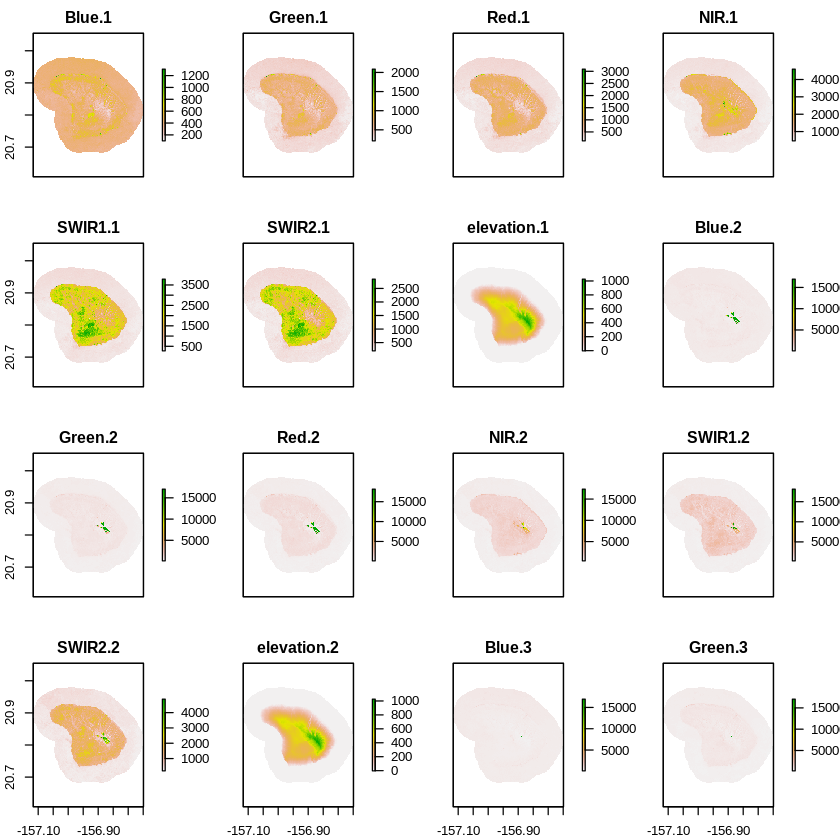

In [75]:
stack_all%>% plot

In [79]:
e <- extent(stack_all)

In [80]:
e

class      : Extent 
xmin       : -157.1164 
xmax       : -156.7491 
ymin       : 20.68128 
ymax       : 20.98096 

In [81]:
e <- extent(ccap_raster)

In [82]:
e

class      : Extent 
xmin       : 700997.6 
xmax       : 729207.2 
ymin       : 2293328 
ymax       : 2316121 

In [ ]:

y_end <- c(seq(1,ccap_raster %>% nrow,512),nrow(ccap_raster))[-1]
x_end <- c(seq(1,ccap_raster %>% ncol,512),ncol(ccap_raster))[-1]

extract_grid <- expand.grid(x_end,y_end) %>% data.table

names(extract_grid) <- c('x_end','y_end')

extract_grid$x_org <- extract_grid$x_end - 512
extract_grid$y_org <- extract_grid$y_end - 512

extract_grid$id <- 1:nrow(extract_grid)